In [2]:
import numpy as np
import pandas as pd


In [3]:
aggtrade= pd.read_csv("/Users/ashwaryabhandarkar/Desktop/regime/data/aggTrade/BNBFDUSD_20250314.txt")
depth20= pd.read_csv("/Users/ashwaryabhandarkar/Desktop/regime/data/depth20_1000ms/BNBFDUSD_20250314.txt")


aggtrade.head(5)


,Time,Price,Quantity,IsMarketMaker,NumTrades,M
0,2025-03-14 00:00:02.764823793 +0530 IST,579.41,0.496,True,1,True
1,2025-03-14 00:00:02.781509697 +0530 IST,579.38,0.013,True,1,True
2,2025-03-14 00:00:02.8057318 +0530 IST,579.38,0.104,True,1,True
3,2025-03-14 00:00:03.902576812 +0530 IST,579.34,0.496,True,1,True
4,2025-03-14 00:00:03.905083833 +0530 IST,579.32,2.739,True,2,True


In [4]:
depth20.head(5)

,Time,BidPriceL20,BidQtyL20,BidPriceL19,BidQtyL19,BidPriceL18,BidQtyL18,BidPriceL17,BidQtyL17,BidPriceL16,...,AskPriceL16,AskQtyL16,AskPriceL17,AskQtyL17,AskPriceL18,AskQtyL18,AskPriceL19,AskQtyL19,AskPriceL20,AskQtyL20
0,2025-03-14 00:00:02.292522546 +0530 IST,579.20,0.621,579.24,0.015,579.25,0.009,579.26,0.013,579.27,...,579.67,1.151,579.68,0.043,579.69,1.258,579.70,0.911,579.71,2.025
1,2025-03-14 00:00:03.292828523 +0530 IST,579.08,2.612,579.09,8.606,579.10,3.453,579.11,3.825,579.12,...,579.59,0.971,579.60,5.071,579.61,4.894,579.62,1.017,579.63,0.048
2,2025-03-14 00:00:04.292889586 +0530 IST,579.14,1.948,579.15,3.957,579.18,1.681,579.19,3.465,579.20,...,579.62,1.017,579.63,0.048,579.64,9.720,579.65,2.025,579.66,0.365
3,2025-03-14 00:00:05.292551566 +0530 IST,579.07,0.013,579.08,0.013,579.09,8.606,579.10,3.453,579.11,...,579.56,0.024,579.57,1.926,579.58,2.127,579.59,0.279,579.60,7.213
4,2025-03-14 00:00:06.292725093 +0530 IST,579.11,9.143,579.12,6.361,579.13,5.837,579.14,2.816,579.15,...,579.56,0.024,579.57,1.926,579.58,2.127,579.59,0.279,579.60,10.469


In [5]:
# Feature Engineering
for i in range(1,21):
    depth20[f'SpreadL{i}'] = depth20[f'BidPriceL{i}'] - depth20[f'AskPriceL{i}']
    depth20[f'imbalance_level{i}']= (depth20[f'BidQtyL{i}'] - depth20[f'AskQtyL{i}'])/(depth20[f'BidQtyL{i}'] + depth20[f'AskQtyL{i}'])
    depth20[f'micro_priceL{i}']= (depth20[f'BidPriceL{i}']*depth20[f'AskQtyL{i}'] + depth20[f'AskPriceL{i}']*depth20[f'BidQtyL{i}'])/(depth20[f'BidQtyL{i}'] + depth20[f'AskQtyL{i}'])

depth20[f'mid_price']= (depth20[f'BidPriceL1']+ depth20[f'AskPriceL1'])/2
depth20[f'Rolling mid-price return']= np.log(depth20[f'mid_price']/depth20[f'mid_price'].shift(1))
depth20[f'Price volatility_10s']= depth20[f'Rolling mid-price return'].rolling(window=10).std()
depth20[f'Price volatility_30s']= depth20[f'Rolling mid-price return'].rolling(window=30).std()
depth20[f'cum_bid_qty']= depth20[[f'BidQtyL{j}' for j in range(1,21)]].sum(axis=1)
depth20[f'cum_ask_qty']= depth20[[f'AskQtyL{j}' for j in range(1,21)]].sum(axis=1)


In [6]:
aggtrade[f'buyvol']=aggtrade.loc[~aggtrade[f'IsMarketMaker'],'Quantity']
aggtrade[f'sellvol']=aggtrade.loc[aggtrade[f'IsMarketMaker'], 'Quantity']
aggtrade[f'buyvol']=aggtrade[f'buyvol'].fillna(0)
aggtrade[f'sellvol']=aggtrade[f'sellvol'].fillna(0)
aggtrade[f'buyvol_10s']=aggtrade[f'buyvol'].rolling(window=10).sum()
aggtrade[f'sellvol_10s']=aggtrade[f'sellvol'].rolling(window=10).sum()
aggtrade[f'buyvol_30s']=aggtrade[f'buyvol'].rolling(window=30).sum()
aggtrade[f'sellvol_30s']=aggtrade[f'sellvol'].rolling(window=30).sum()
aggtrade[f'vol_imbalance']= (aggtrade[f'buyvol']-aggtrade[f'sellvol'])/(aggtrade[f'buyvol']+aggtrade[f'sellvol'] + 1e-9)
aggtrade[f'Qty_cumsum']=aggtrade['Quantity'].cumsum()
aggtrade[f'PQ']= (aggtrade['Price']*aggtrade[f'Quantity']).cumsum()
aggtrade[f'VWAP']= aggtrade[f'PQ']/aggtrade[f'Qty_cumsum']
aggtrade['VWAP_Shift']= aggtrade['VWAP'].rolling(window=10).mean()


In [7]:
from sklearn.linear_model import LinearRegression

level = np.arange(1,21).reshape(-1,1)

def slope(row,side='Bid'):
    qty= np.array([row[f'{side}QtyL{i}'] for i in range(1,21)]).reshape(-1,1)
    model = LinearRegression().fit(level,qty)
    return model.coef_[0][0]

depth20[f'BidSlope']= depth20.apply(lambda row: slope(row,side='Bid'), axis=1)
depth20[f'AskSlope']= depth20.apply(lambda row: slope(row,side='Ask'), axis=1)

In [8]:
depth20[f'BidSlope']


0        0.139941
1        0.141672
2        0.054080
3        0.259286
4        0.368954
           ...   
85350    0.104308
85351    0.157734
85352    0.144778
85353    0.122184
85354    0.140167
Name: BidSlope, Length: 85355, dtype: float64

In [9]:
depth20[f'AskSlope']

0       -0.001229
1        0.087053
2        0.132226
3        0.110089
4        0.164323
           ...   
85350    0.327701
85351    0.262562
85352    0.314286
85353    0.176402
85354    0.306948
Name: AskSlope, Length: 85355, dtype: float64

In [10]:
depth20.head(5)



,Time,BidPriceL20,BidQtyL20,BidPriceL19,BidQtyL19,BidPriceL18,BidQtyL18,BidPriceL17,BidQtyL17,BidPriceL16,...,imbalance_level20,micro_priceL20,mid_price,Rolling mid-price return,Price volatility_10s,Price volatility_30s,cum_bid_qty,cum_ask_qty,BidSlope,AskSlope
0,2025-03-14 00:00:02.292522546 +0530 IST,579.20,0.621,579.24,0.015,579.25,0.009,579.26,0.013,579.27,...,-0.530612,579.319694,579.480,NaN,NaN,NaN,57.149,29.514,0.139941,-0.001229
1,2025-03-14 00:00:03.292828523 +0530 IST,579.08,2.612,579.09,8.606,579.10,3.453,579.11,3.825,579.12,...,0.963910,579.620075,579.400,-0.000138,NaN,NaN,88.726,30.428,0.141672,0.087053
2,2025-03-14 00:00:04.292889586 +0530 IST,579.14,1.948,579.15,3.957,579.18,1.681,579.19,3.465,579.20,...,0.684393,579.577942,579.410,0.000017,NaN,NaN,32.426,46.398,0.054080,0.132226
3,2025-03-14 00:00:05.292551566 +0530 IST,579.07,0.013,579.08,0.013,579.09,8.606,579.10,3.453,579.11,...,-0.996402,579.070954,579.340,-0.000121,NaN,NaN,61.843,44.543,0.259286,0.110089
4,2025-03-14 00:00:06.292725093 +0530 IST,579.11,9.143,579.12,6.361,579.13,5.837,579.14,2.816,579.15,...,-0.067612,579.338435,579.345,0.000009,NaN,NaN,53.561,45.245,0.368954,0.164323


In [11]:
depth20['Time'] = depth20['Time'].str.replace(' IST', '', regex=False)
aggtrade['Time'] = aggtrade['Time'].str.replace(' IST', '', regex=False)

depth20['Time'] = pd.to_datetime(depth20['Time'])
aggtrade['Time'] = pd.to_datetime(aggtrade['Time'])

depth20 = depth20.set_index('Time')

bid_price_level = [f'BidPriceL{i}' for i in range(1, 21)]
ask_price_level = [f'AskPriceL{i}' for i in range(1, 21)]

buy_trade_wipe = []
sell_trade_wipe = []

for idx, row in aggtrade.iterrows():
    trade_price = row['Price']
    trade_time = row['Time']
    is_maker = row['IsMarketMaker']

    closest_time = depth20.index.get_indexer([trade_time], method='nearest')
    if closest_time[0] == -1:
        continue
    else:
        obs_snapshot = depth20.iloc[closest_time[0]]

    wipe_level = 0

    if is_maker:
        for lvl, bid_col in enumerate(bid_price_level, start=1):
            if obs_snapshot[bid_col] >= trade_price:
                wipe_level = lvl
            else:
                break
        
        sell_trade_wipe.append(wipe_level)
        buy_trade_wipe.append(0)

    else:
        for lvl, ask_col in enumerate(ask_price_level, start=1):
            if obs_snapshot[ask_col] <= trade_price:
                wipe_level = lvl
            else:
                break
        
        buy_trade_wipe.append(wipe_level)
        sell_trade_wipe.append(0)

aggtrade[f'Buy_wipelvl'] = buy_trade_wipe
aggtrade[f'Sell_wipelvl'] = sell_trade_wipe



In [12]:
aggtrade['Buy_wipelvl_avg']=aggtrade[f'Buy_wipelvl'].rolling(window=10).mean()
aggtrade['Sell_wipelvl_avg']=aggtrade[f'Sell_wipelvl'].rolling(window=10).mean()

In [16]:
print(depth20.columns.tolist())

['BidPriceL20', 'BidQtyL20', 'BidPriceL19', 'BidQtyL19', 'BidPriceL18', 'BidQtyL18', 'BidPriceL17', 'BidQtyL17', 'BidPriceL16', 'BidQtyL16', 'BidPriceL15', 'BidQtyL15', 'BidPriceL14', 'BidQtyL14', 'BidPriceL13', 'BidQtyL13', 'BidPriceL12', 'BidQtyL12', 'BidPriceL11', 'BidQtyL11', 'BidPriceL10', 'BidQtyL10', 'BidPriceL9', 'BidQtyL9', 'BidPriceL8', 'BidQtyL8', 'BidPriceL7', 'BidQtyL7', 'BidPriceL6', 'BidQtyL6', 'BidPriceL5', 'BidQtyL5', 'BidPriceL4', 'BidQtyL4', 'BidPriceL3', 'BidQtyL3', 'BidPriceL2', 'BidQtyL2', 'BidPriceL1', 'BidQtyL1', 'AskPriceL1', 'AskQtyL1', 'AskPriceL2', 'AskQtyL2', 'AskPriceL3', 'AskQtyL3', 'AskPriceL4', 'AskQtyL4', 'AskPriceL5', 'AskQtyL5', 'AskPriceL6', 'AskQtyL6', 'AskPriceL7', 'AskQtyL7', 'AskPriceL8', 'AskQtyL8', 'AskPriceL9', 'AskQtyL9', 'AskPriceL10', 'AskQtyL10', 'AskPriceL11', 'AskQtyL11', 'AskPriceL12', 'AskQtyL12', 'AskPriceL13', 'AskQtyL13', 'AskPriceL14', 'AskQtyL14', 'AskPriceL15', 'AskQtyL15', 'AskPriceL16', 'AskQtyL16', 'AskPriceL17', 'AskQtyL17',

In [ ]:
from sklearn.preprocessing import StandardScaler

feature_cols1 = ['buyvol_10s', 'sellvol_10s', 'buyvol_30s', 'sellvol_30s',
                 'vol_imbalance', 'Qty_cumsum', 'PQ', 'VWAP', 'VWAP_Shift', 'Buy_wipelvl', 
                 'Sell_wipelvl', 'Buy_wipelvl_avg', 'Sell_wipelvl_avg']

feature_cols2 = ['mid_price', 'Rolling mid-price return', 'Price volatility_10s', 
                 'Price volatility_30s', 'cum_bid_qty', 'cum_ask_qty', 'BidSlope', 'AskSlope']
feature_cols3 = [f'SpreadL{i}' for i in range(1,21)]                
feature_cols4 = [f'imbalance_level{i}' for i in range(1,21)]
feature_cols5 = [f'micro_priceL{i}' for i in range(1,21)]

scaler= StandardScaler()
normalised_array = scaler.fit_transform(aggtrade[feature_cols1]) # contains 13 arrays in 1 array 
normalised_array_dept20_a = scaler.fit_transform(depth20[feature_cols2]) 
normalised_array_dept20_b = scaler.fit_transform(depth20[feature_cols3])
normalised_array_dept20_c = scaler.fit_transform(depth20[feature_cols4])
normalised_array_dept20_d = scaler.fit_transform(depth20[feature_cols5])
normalised_feat1= [normalised_array[:,i] for i in range(normalised_array.shape[1])]
normalised_feat2= [normalised_array_dept20_a[:,i] for i in range(normalised_array_dept20_a.shape[-1])]
normalised_feat3= [normalised_array_dept20_b[:,i] for i in range(normalised_array_dept20_b.shape[-1])]
normalised_feat4= [normalised_array_dept20_c[:,i] for i in range(normalised_array_dept20_c.shape[-1])]
normalised_feat5= [normalised_array_dept20_d[:,i] for i in range(normalised_array_dept20_d.shape[-1])]

# each list (normalised_feat1 to 5) conatins arrays in number equal to number of columns present in feature_cols1 to 5 
# and thus each array contains the normalised values of the features calculated above.

<function matplotlib.pyplot.show(close=None, block=None)>

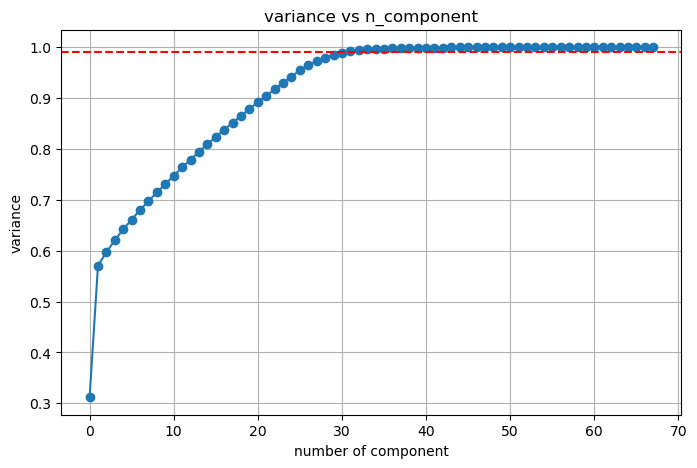

In [124]:
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
norm_features = np.hstack([normalised_array_dept20_a,
                           normalised_array_dept20_b,normalised_array_dept20_c,normalised_array_dept20_d])


impute = SimpleImputer(strategy='mean')
norm_features = impute.fit_transform(norm_features)
norm_features2 = impute.fit_transform(normalised_array)


pca = PCA()
norm_features_pca = pca.fit_transform(norm_features)
variance_cumulative = np.cumsum(pca.explained_variance_ratio_)


plt.figure(figsize=(8,5))
plt.plot(variance_cumulative,marker ='o')
plt.axhline(y = 0.99, color='r',linestyle='--', label='95% variance')
plt.title('variance vs n_component')
plt.xlabel('number of component')
plt.ylabel('variance')
plt.grid(True)
plt.legend
plt.tight_layout
plt.show



In [142]:
# thus the best number of components to take for PCA is given by: 
n_comp = np.argmax(variance_cumulative > 0.99)  + 1
print("Number of ideal components for PCA would be" ,n_comp)
pca = PCA(n_components= n_comp)


Number of ideal components for PCA would be 32


In [143]:
# Reduced Dimension Features for the dataset, shape of features is (85355, 32)

features = pca.fit_transform(norm_features)
features.shape


(85355, 32)

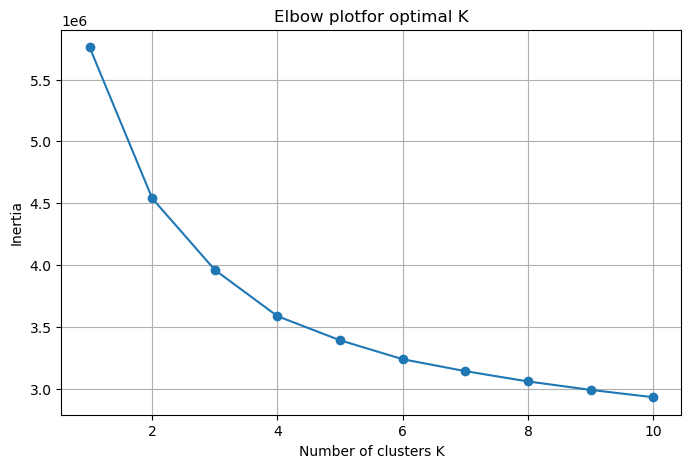

In [149]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inertia = []
for k in range(1,11):
    kmeans = KMeans(n_clusters=k,n_init=10,random_state=42)
    kmeans.fit_transform(features)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8,5))
plt.plot(range(1,11),inertia,marker='o')
plt.title("Elbow plotfor optimal K")
plt.xlabel("Number of clusters K")
plt.ylabel("Inertia")
plt.legend
plt.grid(True)


In [ ]:
# Thus from the Elbow graph we get that K=4
# as after this the graph does not show very large chnages in the inertia value.

In [151]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

k=4
kmeans = KMeans(n_clusters=k,n_init=1,random_state=42)
cluster = kmeans.fit_predict(features)

acc_score = silhouette_score(features,cluster)
print("Clustering Quality is:", round(acc_score,2))

Clustering Quality is: 0.15
